# 作业1

基于矩阵乘法，用 Tensorflow 实现 Lecture 3 最后作业的单隐层神经网络

详见作业2

# 作业2

- 基础代码 tf_matrix.ipynb，将列向量表示形式，改成行向量表示形式
- 进一步，使用 `tf.layers.dense` 替换原有的矩阵乘法

## 修改示例

In [1]:
%load_ext watermark
%watermark

2017-03-27T13:32:01

CPython 2.7.6
IPython 5.1.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.0-21-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [1]:
import tensorflow as tf
import numpy as np

In [12]:
def add_nn_layer(input_, weight, bias, activation=None):
    # 假设 input_ 中每一列是一个样本
    raw_output = tf.add(tf.matmul(input_, weight), bias)
    if activation:
        return activation(raw_output)
    else:
        return raw_output

In [13]:
def generate_weight_and_bias(input_dim, output_dim):
    w = tf.Variable(tf.random_uniform([input_dim, output_dim], -1, 1))
    bias = tf.Variable(tf.zeros([output_dim, 1]))
    return (w, bias)

In [14]:
X = np.concatenate((np.random.rand(50, 2), np.random.rand(50, 2) + 1), axis=0)
# 注意这里要转换成 float32，否则默认可能是精度更高的 float64，和后面 W, b 的类型对应，Tensorflow 的矩阵乘法不会自己做类型转化。
# 也可以在矩阵乘法中使用 tf.cast(x, tf.float32) 来转换类型
X = X.astype(np.float32)
y = np.asarray([0] * 50 + [1] * 50)

In [15]:
W, b = generate_weight_and_bias(2, 1)
nn_output = add_nn_layer(X, W, b, tf.sigmoid)

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    res = sess.run(nn_output)

In [17]:
res.shape

(100, 1)

###  Tensorflow 中的 sigmoid + cross entropy
如果看过作业中 "Neural Network and Deep Learning" Simgoid + cross entropy 相关章节的话，应该能理解，sigmoid + cross entropy 在求导数的时候，可以把分母进行约简，少做一些计算。
Tensorflow 利用了这一特性进行计算约简，因此其有一个专门的 cost 层，叫 tf.nn.sigmoid_cross_entropy_with_logits
所谓的 logit，其实是 sigmoid 的反函数，也就是说这个 cost 函数，需要的输入是 sigmoid 变换之后的结果，再取其反函数 logit。
这么这个结果，其实就是我们神经网络输出节点的原始结果，即在 sigmoid 变换之前的结果。
为了配合这个 cost 层进行计算约简，我们需要先准备一个 sigmoid 激活之前的结果，在训练时使用激活之前的结果即可，在『预测』时才使用 sigmoid 激活之后的结果

In [18]:
tf.reset_default_graph()

In [19]:
W, b = generate_weight_and_bias(2, 1)
# X, y 这里是用 numpy array 的方式， Tensorflow 会将他们变成 Constant tensor 放入 graph 当中
# **请尝试将 X, y 改成 tensorflow 的 placeholder 形式**

nn_raw_output = add_nn_layer(X, W, b)
final_output = tf.sigmoid(nn_raw_output)

In [20]:
cost = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=nn_raw_output, labels=y.reshape(100,1).astype(np.float32))
)

In [21]:
def accuracy(preds, labels):
    return ((preds > 0.5) == labels).sum() / float(len(labels))

In [22]:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        sess.run(train_step)
        if i % 50== 0:
            preds = sess.run(final_output)
            print(accuracy(preds, y.reshape(100,1)))

0.4
0.68
0.88
0.94
0.95
0.98
0.99
0.99
0.99
0.99
0.99
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


## 修改 ch3 作业（按列）

In [23]:
data = []
with open('../w3_Tensorflow-NN/data.csv', 'r') as f:
    for line in f.readlines():
        data.append(line.strip().split(','))
        
        
X_train = []
y_train = []
for i in range(len(data)):
    X_train.append((float(data[i][0]), float(data[i][1])))
    y_train.append(int(data[i][2]))

xtrain = np.array(X_train, dtype=np.float32)
ytrain = np.array(y_train, dtype=np.int32)

0.59
0.915
1.0
1.0
1.0
Automatically created module for IPython interactive environment


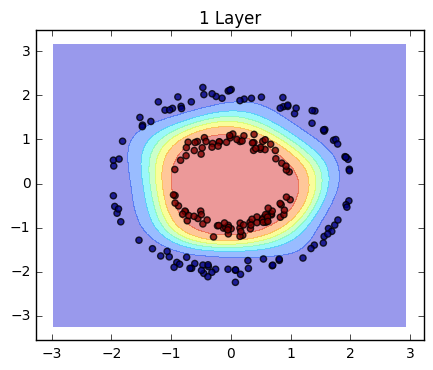

In [24]:
x_placeholder = tf.placeholder('float')
y_placeholder = tf.placeholder('float')

n = 30

W1 = tf.Variable(tf.random_uniform([2, n]), dtype=tf.float32)
b1 = tf.Variable(tf.random_uniform([1, n]), dtype=tf.float32)

W2 = tf.Variable(tf.random_uniform([n, 1]), dtype=tf.float32)
b2 = tf.Variable(tf.random_uniform([1, 1]), dtype=tf.float32)

hidden = tf.add(tf.matmul(x_placeholder, W1), b1)
nn_raw_output = tf.add(tf.matmul(tf.tanh(hidden), W2), b2)
final_output = tf.sigmoid(nn_raw_output)

cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nn_raw_output, labels=y_placeholder))


train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
costs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        # type 可以不指定形式，数据初始读入的时候已经指定
        feed_dict = {x_placeholder:xtrain.astype(float), y_placeholder:ytrain.reshape(200,1).astype(float)}
        sess.run(train_step, feed_dict=feed_dict)
        cost_value = sess.run(cost, feed_dict=feed_dict)
        costs.append(cost_value)
        if i % 200 == 0:
            preds = sess.run(final_output, feed_dict=feed_dict)
            print(accuracy(preds, ytrain.reshape(len(ytrain),1)))
    W1L1, b1L1 = (sess.run([W1, b1]))
    W1L2, b1L2 = (sess.run([W2, b2]))


print(__doc__)

from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
#iris = datasets.load_iris()
#X = iris.data[:, [0, 2]]
#y = iris.target
# X.shape = 150, 2
X = xtrain
# y.shape = 150,
y = ytrain

# Training classifiers
#clf1 = DecisionTreeClassifier(max_depth=4)
#clf1.fit(X, y)

def sigmoid(x):
    return 1/(1+np.e ** (-x))

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))


temp = np.c_[xx.ravel(), yy.ravel()]
M1L = np.tanh(temp.dot(W1L1) + b1L1)
M2L = sigmoid(M1L.dot(W1L2) + b1L2)


Z = M2L.reshape(xx.shape)

axarr.contourf(xx, yy, Z, alpha=0.4)
axarr.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
axarr.set_title("1 Layer")

plt.show()

## 修改 ch3 作业（按函数和矩阵）

In [25]:
data = []
with open('../w3_Tensorflow-NN/data.csv', 'r') as f:
    for line in f.readlines():
        data.append(line.strip().split(','))
        
        
X_train = []
y_train = []
for i in range(len(data)):
    X_train.append((float(data[i][0]), float(data[i][1])))
    y_train.append(int(data[i][2]))

xtrain = np.array(X_train, dtype=np.float32)
ytrain = np.array(y_train, dtype=np.int32)

In [26]:
def generate_weight_and_bias(input_dim, output_dim):
    w = tf.Variable(tf.random_uniform([input_dim, output_dim], -1, 1))
    bias = tf.Variable(tf.zeros([1, output_dim]))
    return (w, bias)

In [27]:
def add_nn_layer(input_, weight, bias, activation=None):
    # 假设 input_ 中每一列是一个样本
    raw_output = tf.add(tf.matmul(input_, weight), bias)
    if activation:
        return activation(raw_output)
    else:
        return raw_output

0.49
0.885
0.88
0.885
0.885
0.89
0.885
0.885
0.885
0.885
Automatically created module for IPython interactive environment


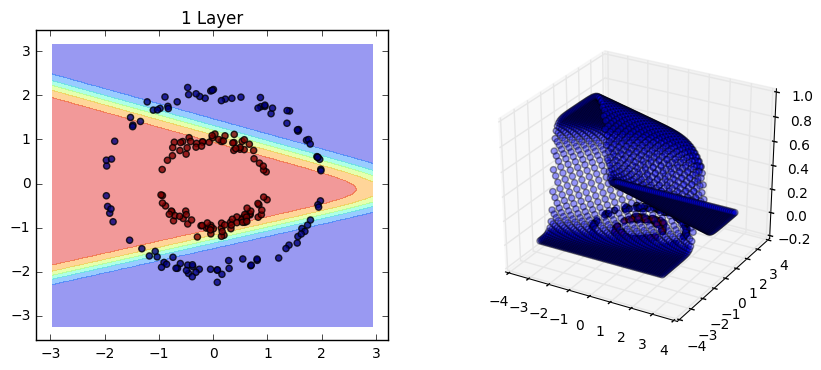

In [57]:
x_placeholder = tf.placeholder('float')
y_placeholder = tf.placeholder('float')

n = 2
W1, b1 = generate_weight_and_bias(2, n)
W2, b2 = generate_weight_and_bias(n, 1)


hidden = add_nn_layer(xtrain, W1, b1)
nn_raw_output = add_nn_layer(tf.tanh(hidden), W2, b2)
final_output = tf.sigmoid(nn_raw_output)


cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nn_raw_output, labels=y_placeholder))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
costs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        # type 可以不指定形式，数据初始读入的时候已经指定
        # 注意 y 为列向量时，这里需要 reshape，可能是因为向量默认是行的
        # 这里 x 传入的是行向量
        feed_dict = {x_placeholder:xtrain.astype(float), y_placeholder:ytrain.reshape(200,1).astype(float)}
        sess.run(train_step, feed_dict=feed_dict)
        cost_value = sess.run(cost, feed_dict=feed_dict)
        costs.append(cost_value)
        if i % 200 == 0:
            preds = sess.run(final_output, feed_dict=feed_dict)
            # accuracy 也需要 reshape，原因也是因为向量默认是行的
            print(accuracy(preds, ytrain.reshape(len(ytrain),1)))
    W1L1, b1L1 = (sess.run([W1, b1]))
    W1L2, b1L2 = (sess.run([W2, b2]))



print(__doc__)

from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
#iris = datasets.load_iris()
#X = iris.data[:, [0, 2]]
#y = iris.target
# X.shape = 150, 2
X = xtrain
# y.shape = 150,
y = ytrain

# Training classifiers
#clf1 = DecisionTreeClassifier(max_depth=4)
#clf1.fit(X, y)

def sigmoid(x):
    return 1/(1+np.e ** (-x))

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f = plt.figure(figsize=(10,4))


temp = np.c_[xx.ravel(), yy.ravel()]
M1L = np.tanh(temp.dot(W1L1) + b1L1)
M2L = sigmoid(M1L.dot(W1L2) + b1L2)


Z = M2L.reshape(xx.shape)

ax0 = f.add_subplot(121,)
ax0.contourf(xx, yy, Z, alpha=0.4)
ax0.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
ax0.set_title("1 Layer")

ax1 = f.add_subplot(122, projection='3d')
ax1.scatter(xx.ravel(), yy.ravel(), Z.ravel(), alpha=0.4)
ax1.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

plt.show()

## 修改 ch3 作业（按 tf.layers.dense）

In [16]:
!head '../w3_Tensorflow-NN/data.csv'

0.3444989038,1.9351813391,0
-0.1924808336,0.9426635874,1
0.5827218693,-0.8801240557,1
0.1515495372,-1.0116493917,1
0.5450826897,-1.7135021017,0
-0.9353328106,-0.2729427047,1
0.82811985,-0.7647471505,1
-0.5620270118,0.9530543344,1
0.8105408238,-1.7446970434,0
0.075898852,-1.9698145755,0


#### 另一种读取方法

In [23]:
raw_data = np.loadtxt('../w3_Tensorflow-NN/data.csv', delimiter=',', usecols=(0,1,2), unpack=True)

In [56]:
xtrain = np.array(raw_data[:2,:].T,dtype=np.float32)

In [59]:
ytrain = np.array(raw_data[2, :], dtype=np.float32)

In [65]:
def accuracy(preds, labels):
    return ((preds > 0.5) == labels).sum() / float(len(labels))

In [163]:
x_placeholder = tf.placeholder('float')
y_placeholder = tf.placeholder('float')

n = 5

W1 = tf.Variable(tf.random_uniform([2, n]), dtype=tf.float32)
W2 = tf.Variable(tf.random_uniform([n, 1]), dtype=tf.float32)

hidden = tf.layers.dense(inputs=tf.matmul(x_placeholder,W1), units=n, activation=tf.tanh)
nn_raw_output = tf.layers.dense(inputs=tf.matmul(hidden,W2), units=1, activation=None)
#hidden = add_nn_layer(xtrain, W1, b1)
#nn_raw_output = add_nn_layer(tf.tanh(hidden), W2, b2)
final_output = tf.sigmoid(nn_raw_output)


cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nn_raw_output, labels=y_placeholder))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
costs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        # type 可以不指定形式，数据初始读入的时候已经指定
        # 注意 y 为列向量时，这里需要 reshape，可能是因为向量默认是行的
        # 这里 x 传入的是行向量
        feed_dict = {x_placeholder:xtrain.astype(float), y_placeholder:ytrain.reshape(200,1).astype(float)}
        sess.run(train_step, feed_dict=feed_dict)
        cost_value = sess.run(cost, feed_dict=feed_dict)
        costs.append(cost_value)
        if i % 200 == 0:
            preds = sess.run(final_output, feed_dict=feed_dict)
            # accuracy 也需要 reshape，原因也是因为向量默认是行的
            print(accuracy(preds, ytrain.reshape(len(ytrain),1)))
"""    W1L1, b1L1 = (sess.run([W1, b1]))
    W1L2, b1L2 = (sess.run([W2, b2]))



print(__doc__)

from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
#iris = datasets.load_iris()
#X = iris.data[:, [0, 2]]
#y = iris.target
# X.shape = 150, 2
X = xtrain
# y.shape = 150,
y = ytrain

# Training classifiers
#clf1 = DecisionTreeClassifier(max_depth=4)
#clf1.fit(X, y)

def sigmoid(x):
    return 1/(1+np.e ** (-x))

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f = plt.figure(figsize=(10,4))


temp = np.c_[xx.ravel(), yy.ravel()]
M1L = np.tanh(temp.dot(W1L1) + b1L1)
M2L = sigmoid(M1L.dot(W1L2) + b1L2)


Z = M2L.reshape(xx.shape)

ax0 = f.add_subplot(121,)
ax0.contourf(xx, yy, Z, alpha=0.4)
ax0.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
ax0.set_title("1 Layer")

ax1 = f.add_subplot(122, projection='3d')
ax1.scatter(xx.ravel(), yy.ravel(), Z.ravel(), alpha=0.4)
ax1.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

plt.show()"""

0.45
0.73
0.835
1.0
1.0


'    W1L1, b1L1 = (sess.run([W1, b1]))\n    W1L2, b1L2 = (sess.run([W2, b2]))\n\n\n\nprint(__doc__)\n\nfrom itertools import product\n\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\n\nfrom sklearn import datasets\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.ensemble import VotingClassifier\n\n# Loading some example data\n#iris = datasets.load_iris()\n#X = iris.data[:, [0, 2]]\n#y = iris.target\n# X.shape = 150, 2\nX = xtrain\n# y.shape = 150,\ny = ytrain\n\n# Training classifiers\n#clf1 = DecisionTreeClassifier(max_depth=4)\n#clf1.fit(X, y)\n\ndef sigmoid(x):\n    return 1/(1+np.e ** (-x))\n\n# Plotting decision regions\nx_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1\ny_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1\nxx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),\n                     np.arange(y_min, y_max, 0.1))\n\nf = plt.figu

## layer.desnse2

In [178]:
raw_data = np.loadtxt('../w3_Tensorflow-NN/data.csv', delimiter=',', usecols=(0,1,2), unpack=True)
xtrain = np.array(raw_data[:2,:].T,dtype=np.float32)
ytrain = np.array(raw_data[2, :], dtype=np.float32)

In [180]:
xtrain.shape

(200, 2)

In [179]:
def accuracy(preds, labels):
    return ((preds > 0.5) == labels).sum() / float(len(labels))

In [184]:
x_placeholder = tf.placeholder('float', [None, 2])
y_placeholder = tf.placeholder('float', [None, 1])

n = 5

hidden = tf.layers.dense(inputs=x_placeholder, units=n, activation=tf.tanh)
nn_raw_output = tf.layers.dense(inputs=hidden, units=1, activation=None)
final_output = tf.sigmoid(nn_raw_output)


cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nn_raw_output, labels=y_placeholder))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
costs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        # type 可以不指定形式，数据初始读入的时候已经指定
        # 注意 y 为列向量时，这里需要 reshape，可能是因为向量默认是行的
        # 这里 x 传入的是行向量
        feed_dict = {x_placeholder:xtrain.astype(float), y_placeholder:ytrain.reshape(200,1).astype(float)}
        sess.run(train_step, feed_dict=feed_dict)
        cost_value = sess.run(cost, feed_dict=feed_dict)
        costs.append(cost_value)
        if i % 200 == 0:
            preds = sess.run(final_output, feed_dict=feed_dict)
            # accuracy 也需要 reshape，原因也是因为向量默认是行的
            print(accuracy(preds, ytrain.reshape(len(ytrain),1)))

0.54
0.875
0.94
0.975
1.0
1.0
1.0
1.0
1.0
1.0


# 作业3

为什么取这个矩阵的某一行，和这个词出现的时候做矩阵乘法，结果是一样的呢？

## 构建一个词的 Word Embedding

在构建统计语言模型的时候，我们把所有看到的词都放入了 dict 里面，这时候影响不大，因为每个词占用的内存较小。  
在使用神经网络做自然语言处理的时候，我们一般都会对词表做一个截断操作，取最高频的 n 个（也有人按词频阈值做截断）。  

这样有两个好处：
- 减少模型的内存使用。
- 只出现过一两次的词，在整个优化过程中往往也很难学好。不如把这些词直接全看成未登录词。


In [2]:
tf.reset_default_graph()

In [3]:
# 决定了 embedding 的维度 （隐层节点数）
word_embedding_dim = 128
# 决定了词表数量, 预留一个未登录词
vocab_size = 80000 + 1
UNK_IDX = 0

# 这里需要把 Word embedding 放到 Variable 里面。因为 Word embedding 是要随机初始化，跟着数据不断变化的。
# 它相当于普通神经网络中的权重。

# 在梯度下降时， tensorflow 的 Optimizer 会自动找到 Graph 中的 Variable，计算梯度并进行更新。
word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))

# placeholder 和 variable 基本都可以当做 Tensor 来用
# 注意这里的输入是 int32 类型，表示一个词 ID。
# 这里我们需要对数据进行预处理，以把高频词映射到 [1, 80000] 之间，不在词表里面的词设置成 UNK, ID 为 0
# 这里我们假设输入是两个词

# 这里 Shape 的第一维我们指定为 None，是表示第一维可以根据数据进行变化，因此同样一个程序可以适应梯度下降时不同的 batch_size
input_data = tf.placeholder(tf.int32, shape=[None, 2], name='input_data')

input_embeds = tf.nn.embedding_lookup(word_embedding, input_data)

In [7]:
word_embedding

In [8]:
input_data

<tf.Tensor 'input_data:0' shape=(?, 2) dtype=int32>

In [10]:
tf.nn.embedding_lookup?

因为 input_data 是一个二维矩阵，lookup 之后得到的其实是一个『三维的矩阵』  
怎么理解呢？如果我们一个样本有两个词，拿到的就是矩阵的两行，因此是一个矩阵  
但是我们同时有多个样本，因此需要对这个矩阵再『扩张』一个维度。而这个维度因为数据还未给出，大小是未知的

In [153]:
input_embeds

<tf.Tensor 'embedding_lookup:0' shape=(?, 2, 128) dtype=float32>

### 两个词的向量做相加

In [11]:
# reduce 开头的函数一般有一个 axis 参数，决定按行、按列或者按整个矩阵进行 reduce
context_embeds = tf.reduce_sum(input_embeds, axis=1)

In [12]:
# 注意观察 context_embds 的 shape
# 因为 placeholder 第一位的维度是 None，这里 TF 没法确切知道第一维最后的 shape
context_embeds

<tf.Tensor 'Sum:0' shape=(?, 128) dtype=float32>

### 相加的词向量再映射到 N 个词的概率分布

In [13]:
# 激活之前的输出
raw_output = tf.layers.dense(context_embeds, vocab_size)

In [14]:
# 加 softmax 之后的输出
output = tf.nn.softmax(raw_output)

In [16]:
tf.layers.dense?

In [158]:
import numpy as np

In [18]:
with tf.Session() as sess:
    # 因为引入了 variable，所以需要进行初始化
    sess.run(tf.global_variables_initializer())
    # 输出的矩阵比较大，我们只看前 10 列
    print(sess.run(output, feed_dict={input_data: np.asarray([[1, 2]])})[:, :10])

[[  1.26213718e-05   1.18030230e-05   1.35719974e-05   1.11542940e-05
    1.39103313e-05   1.25215029e-05   1.27418898e-05   1.16715064e-05
    1.27963949e-05   1.22305401e-05]]


同第三讲示例代码中的类似 (sigmoid + cross entropy)，softmax 配合 cross entropy 的时候，在求导时两个连着看，也可以做分母的消除，因此在计算 cost 的时候我们要把 raw_output 喂给 tf 的这个损失函数

In [19]:
# 样本的 labels 也需要用 placeholder 放置
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

# 因为我们每个样本的 label 只有一个，使用稠密的 softmax 算 cost 及求导太浪费了。这里使用 sparse 版本即可。
# 如果你的 label 是完整的 N 个词上的概率分布，这时候可以使用 tf.nn.softmax_cross_entropy_with_logits
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=raw_output, labels=labels)

In [22]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    dummy_feed_dict = {input_data: np.asarray([[1, 2]]),
                       labels: np.asarray([3])}
    for i in range(100):
        sess.run(train_step, feed_dict=dummy_feed_dict)
        if i % 20 == 0:
            print("Iteration %d" % i)
            print("Cost: %f" % cost.eval(feed_dict=dummy_feed_dict)[0])
            # 查看输出中 ID == 3 的概率
            print("Probability: %f" % output.eval(feed_dict=dummy_feed_dict)[0, 3])
            print("------")

Iteration 0
Cost: 9.525263
Probability: 0.000073
------
Iteration 20
Cost: 0.038387
Probability: 0.962340
------
Iteration 40
Cost: 0.016868
Probability: 0.983274
------
Iteration 60
Cost: 0.010157
Probability: 0.989894
------
Iteration 80
Cost: 0.008024
Probability: 0.992008
------


## 作业4

请根据这个基本的框架程序进行扩展，使用你的语料库进行训练。并完成 3 个名词各自最相近的 Top 10 个词的检索

In [221]:
%matplotlib inline
from collections import Counter
import jieba
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

1.0.1


### 定义参数

In [222]:
# 决定了 embedding 的维度 （隐层节点数）
word_embedding_dim = 30
# 决定了词表数量, 预留一个未登录词
vocab_size = 400 + 1
UNK_IDX = 0

### 定义变量

In [223]:
word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))
input_data = tf.placeholder(tf.int32, shape=[None, 2], name='input_data')
input_embeds = tf.nn.embedding_lookup(word_embedding, input_data)

### 词向量相加

In [224]:
context_embeds = tf.reduce_sum(input_embeds, axis=1)

In [225]:
context_embeds

<tf.Tensor 'Sum_1:0' shape=(?, 30) dtype=float32>

### 映射到 N 个词的概率分布

In [226]:
# raw_output 是一个 vocab_size 维的数据，对比 labels 计算 cost
# 假设输入一组（也就是 两个词），输出因为词向量相加过了，所以就是一个词的词向量：one-hot？
raw_output = tf.layers.dense(context_embeds, vocab_size)
# 如果输入一组，输出的 softmax 是预测的 one-hot 的概率分布？最可能的那个输出词概率最大？
output = tf.nn.softmax(raw_output)

In [227]:
raw_output

<tf.Tensor 'dense_10/BiasAdd:0' shape=(?, 401) dtype=float32>

In [228]:
output

<tf.Tensor 'Softmax_1:0' shape=(?, 401) dtype=float32>

### cost

In [229]:
# 样本的 labels 也需要用 placeholder 放置
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

# 因为我们每个样本的 label 只有一个，使用稠密的 softmax 算 cost 及求导太浪费了。这里使用 sparse 版本即可。
# 如果你的 label 是完整的 N 个词上的概率分布，这时候可以使用 tf.nn.softmax_cross_entropy_with_logits
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=raw_output, labels=labels)

### 读取语料，生成训练数据

In [195]:
#with open('../AssisantEvaluate/xiyouji.txt') as f:
#    corpus = f.read(9995)
#words = [w for w in jieba.cut(corpus.strip().decode('utf-8')) if w not in ' \n']

In [207]:
import jieba
import jieba.posseg as pseg
line_no = 0
words = []
with open('../AssisantEvaluate/xiyouji.txt', 'r') as f:
    for line in f.readlines():
        line_no += 1
        if line_no > 1000:
            break
        word = pseg.cut(line.strip().decode('utf-8')) # 去掉末尾的 '\n'
        for w,f in word:
            if f == 'x':
                continue
            words.append(w)

In [208]:
len(words)

12951

In [209]:
# 统计词频
word_cnt = Counter(words)

In [210]:
len(word_cnt)

4271

In [211]:
# 高频截断
vocab = [i[0] for i in word_cnt.most_common(vocab_size - 1)]

In [212]:
vocab2 = [i for i in word_cnt.most_common(vocab_size - 1)]

In [213]:
# 插入未登录词
vocab.insert(UNK_IDX, 'UNK')

In [214]:
len(vocab)

401

In [215]:
# 映射 id
word_ids = [vocab.index(word) if (word in vocab) else 0
            for word in words]

In [216]:
len(word_ids)

12951

In [217]:
# 生成训练数据
inputs_train = np.asarray(
                [[word_ids[i-1], word_ids[i+1]] for i in range(1, len(word_ids) - 1)])
labels_train = np.asarray(word_ids[1:-1])

In [218]:
inputs_train.shape

(12949, 2)

In [219]:
labels_train.shape

(12949,)

### 训练模型

In [269]:
train_step = tf.train.GradientDescentOptimizer(0.0002).minimize(cost)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    dummy_feed_dict = {input_data: inputs_train,
                       labels: labels_train}
    for i in range(1000):
        sess.run(train_step, feed_dict=dummy_feed_dict)
        if i % 200 == 0:
            print("Iteration %d" % i)
            print("Cost 矩阵：")
            print(cost.eval(feed_dict=dummy_feed_dict))
            print("cost 长度：%d" % len(cost.eval(feed_dict=dummy_feed_dict)))
            # 查看输出中 ID == 30 的概率
            print("Output 长度: %d" % len(output.eval(feed_dict=dummy_feed_dict)[0]))
            print(output.eval(feed_dict=dummy_feed_dict).shape)
            print(output.eval(feed_dict=dummy_feed_dict)[0].shape)
            print("Output 矩阵：")
            print(output.eval(feed_dict=dummy_feed_dict))
            print("Probability: %f" % output.eval(feed_dict=dummy_feed_dict)[1, 30])
            print("------")
            # 词向量是 context_embeds 吗？
            allwords_embedding = context_embeds.eval(feed_dict=dummy_feed_dict)
            test = raw_output.eval(feed_dict=dummy_feed_dict)

Iteration 0
Cost 矩阵：
[  0.           0.           0.         ...,   0.          36.60704803
  34.88500977]
cost 长度：12949
Output 长度: 401
(12949, 401)
(401,)
Output 矩阵：
[[  1.00000000e+00   1.38533033e-16   1.41822591e-16 ...,   1.93322598e-17
    2.44685832e-17   1.44610329e-17]
 [  1.00000000e+00   1.38533033e-16   1.41822591e-16 ...,   1.93322598e-17
    2.44685832e-17   1.44610329e-17]
 [  1.00000000e+00   1.38533033e-16   1.41822591e-16 ...,   1.93322598e-17
    2.44685832e-17   1.44610329e-17]
 ..., 
 [  1.00000000e+00   5.87517976e-15   6.57321623e-15 ...,   1.13659455e-15
    1.30988510e-15   8.18552100e-16]
 [  1.00000000e+00   8.02998563e-16   9.59594520e-16 ...,   1.09573188e-16
    1.27951169e-16   8.47271705e-17]
 [  1.00000000e+00   5.87517976e-15   6.57321623e-15 ...,   1.13659455e-15
    1.30988510e-15   8.18552100e-16]]
Probability: 0.000000
------
Iteration 200
Cost 矩阵：
[ 0.17699558  0.17699558  0.17699558 ...,  1.13401961  6.96126509
  6.78962612]
cost 长度：12949
Output 

### 计算近义词

In [265]:
def sim_words(word, top_k=10):
    
    a = allwords_embedding
    id_ = vocab.index(word.decode('utf-8'))
    
    len_array = np.diag(a.dot(a.T)) ** 0.5
    cos_array = a.dot(a[id_]) / len_array
    cos_dict = dict(zip(cos_array, words[1:-1]))
    sort_cos_dict = sorted(cos_dict.items(), key=lambda x: x[0], reverse=True)
    
    
    return sort_cos_dict[0:top_k]

In [271]:
result = sim_words('三藏')
for k,v in result:
    print k,v

2.64695 方法
2.16307 不足
2.14865 物资
2.0807 诗
2.03983 来
2.03324 铜环
1.96969 潜灵
1.93315 孙悟空
1.92911 故
1.92464 不下


In [261]:
for w,c in vocab2[0:20]:
    print("%s %d" % (w, c))

道 299
了 273
我 265
他 215
的 213
你 207
那 160
是 146
三藏 139
行者 117
有 115
去 95
这 92
又 92
来 90
也 84
在 83
不 76
师父 70
见 65


### 另一种方法计算相似度

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [ ]:
trained_embeddings_sparse = sparse.csr_matrix(trained_embeddings)

In [ ]:
similarities = cosine_similarity(trained_embeddings_sparse)

In [6]:
sparse?

In [4]:
from scipy import sparse
from numpy import array
I = array([0,3,1,0])
J = array([0,3,1,2])
V = array([4,5,7,9])
A = sparse.coo_matrix((V,(I,J)),shape=(4,4))

In [5]:
A

<4x4 sparse matrix of type '<type 'numpy.int64'>'
	with 4 stored elements in COOrdinate format>

In [ ]:
def check(x):
    k = vocab_word2id[x]
    target = similarities[k][1:]
    for i in range(3):
        print(vocab_id2word[np.argsort(-target)[i]], np.sort(target)[::-1][i])

- 词向量就是 weight
- 相似的向量在语义上也比较相似，因为有相似的上下文